# Object-Oriented Demo

---

This is a demo for the class-based features of `climpred` that are in development.

Author: Riley X. Brady (riley.brady@colorado.edu)

Date Last Updated: May 17th, 2019

## Object Types

There are two types of objects that can be used in `climpred`, and both are built on top of `xarray`'s `Dataset` and `DataArray` objects.

1. `HindcastEnsemble`: This is a climate prediction ensemble that is initialized from some observation-based product. This could be observations, an assimilative product, a reconstruction, etc. The point is that this ensemble is making retrospective forecasts (hindcasts) of the real world.
1. `PerfectModelEnsemble`: This is a climate prediction ensemble that is initialized from a control run, using the "perfect model" framework.

Both the `HindcastEnsemble` and `PerfectModelEnsemble` are sub-classes of a `PredictionEnsemble`.

## Functions

Functions can be called directly on the `HindcastEnsemble` or `PerfectModelEnsemble` object. `climpred` manages the nitty-gritty of calling the appropriate functions and applying statistics to multiple simulations/observations and variables.

### HindcastEnsemble Functions

These are the current functions that are supported for `HindcastEnsemble`s. More will be added in the future.

1. `add_reference`: Add a reference simulation/observation to compare the initialized ensemble to.
1. `add_uninitialized`: Add an uninitialized companion ensemble.
1. `compute_metric`: Compare the initialized ensemble to references, e.g., pearson correlation, mean absolute error, root mean square error.
1. `compute_uninitialized`: Compare the uninitialized ensemble to references.
1. `compute_persistence`: Compute a persistence forecast on a reference.


### PerfectModelEnsemble Functions

These are the current functions that are supported for `PerfectModelEnsemble`s. More will be added in the future.

1. `add_control`: Add the control run that initialized the climate prediction ensemble.
1. `generate_uninitialized`: Generate an uninitialized ensemble by bootstrapping the initialized ensemble.
1. `compute_metric`: Compare the initialized ensemble to the control run.
1. `compute_persistence`: Compute a persistence forecast for the control run.
1. `compute_uninitialized`: Compare the uninitialized ensemble to the control.
1. `bootstrap`: Bootstrap the ensemble simulations with replacement.

In [2]:
import numpy as np
import xarray as xr
import climpred as cp
import matplotlib.pyplot as plt
%matplotlib inline
from climpred.loadutils import open_dataset

In [3]:
open_dataset()

'MPI-PM-DP-1D': decadal prediction ensemble area averages of SST/SSS/AMO.
'MPI-PM-DP-3D': decadal prediction ensemble lat/lon/time of SST/SSS/AMO.
'MPI-control-1D': area averages for the control run of SST/SSS.
'MPI-control-3D': lat/lon/time for the control run of SST/SSS.
'CESM-DP-SST': decadal prediction ensemble of global mean SSTs.
'CESM-DP-SSS': decadal prediction ensemble of global mean SSS.
'CESM-LE': uninitialized ensemble of global mean SSTs.
'MPIESM_miklip_baseline1-hind-SST-global': initialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-hist-SST-global': uninitialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-assim-SST-global': assimilation in MPI-ESM of global mean SSTs
'ERSST': observations of global mean SSTs.
'FOSI-SST': reconstruction of global mean SSTs.
'FOSI-SSS': reconstruction of global mean SSS.


# HindcastEnsemble

Here I will use the Community Earth System Model Decadal Prediction Large Ensemble (CESM-DPLE) for a demonstration of the `HindcastEnsemble` capabilities. CESM-DPLE is initialized on November 1st from 1955-2017 by a Forced Ocean Sea-Ice (FOSI) reconstruction simulation. 


I use the FOSI output as a reference for potential predictability of the CESM-DPLE. I load in ERSST observations for a skill assessment of CESM-DPLE. Lastly, I use the CESM Large Ensemble (CESM-LE) as the uninitialized counterpart of the CESM-DPLE. This was generated by perturbing the CESM atmospheric temperature in 1920 slightly to generate an ensemble that diverges due to the chaotic nature of the climate system.

## References

Details on the CESM-DPLE experimental setup:

1. Yeager, S. G., et al. "Predicting near-term changes in the Earth System: A large ensemble of initialized decadal prediction simulations using the Community Earth System Model." Bulletin of the American Meteorological Society 99.9 (2018): 1867-1886.

Details on the ERSST observations:

2. https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5

Details on the CESM Large Ensemble:

3. Kay, J. E., et al. "The Community Earth System Model (CESM) large ensemble project: A community resource for studying climate change in the presence of internal climate variability." Bulletin of the American Meteorological Society 96.8 (2015): 1333-1349.

Here we load the sample data included in `climpred`.

In [4]:
def _load_dple():
    sst = open_dataset('CESM-DP-SST')
    sss = open_dataset('CESM-DP-SSS')
    dple = xr.merge([sst, sss])
    dple = dple.sel(init=slice(1955, 2015))
    # detrend
    dple['SST'] = cp.stats.rm_trend(dple['SST'], dim='init')
    dple['SSS'] = cp.stats.rm_trend(dple['SSS'], dim='init')
    return dple

def _load_fosi():
    sst = open_dataset('FOSI-SST')
    sss = open_dataset('FOSI-SSS')
    fosi = xr.merge([sst, sss])
    fosi = fosi.sel(time=slice(1955, 2015))
    # move to anomaly space
    fosi = fosi - fosi.sel(time=slice(1964, 2014)).mean('time')
    # detrend
    fosi['SST'] = cp.stats.rm_trend(fosi['SST'])
    fosi['SSS'] = cp.stats.rm_trend(fosi['SSS'])
    return fosi

def _load_data():
    data = open_dataset('ERSST')['SST']
    # move to anomaly space
    data = data - data.sel(time=slice(1964, 2014)).mean('time')
    # detrend
    data = cp.stats.rm_trend(data)
    data.name = 'SST'
    return data

def _load_cesmLE():
    lens = open_dataset('CESM-LE')
    # Take ensemble mean for this demo
    lens = lens.mean('member')
    return lens

dple = _load_dple()
fosi = _load_fosi()
data = _load_data().to_dataset()
cesmLE = _load_cesmLE()

The `HindcastEnsemble` object is created just by inputting the prediction ensemble output. Other reference objects can be added after it is generated.

In [5]:
dp = cp.HindcastEnsemble(dple)
print(dp)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 -0.0006536 -0.02718 ... 0.07729 0.1068
    SSS      (init, lead, member) float64 0.01292 0.002436 ... -0.02315
References:
    None
Uninitialized:
    None


For a `HindcastEnsemble` object, you can add multiple references. Here, we will add the reconstruction (FOSI) and observations (ERSST). Multiple checks go into play here under the hood, ensuring that dimensions are named according to our rules and that references match all initialized dimensions (except for time).

We can also have multiple variables per reference and decadal prediction object.

In [6]:
dp.add_reference(fosi, 'FOSI')
dp.add_reference(data, 'ERSST')
print(dp)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 -0.0006536 -0.02718 ... 0.07729 0.1068
    SSS      (init, lead, member) float64 0.01292 0.002436 ... -0.02315
FOSI:
    SST      (time) float64 -0.05523 -0.0491 0.1105 ... -0.01553 0.03564 0.1673
    SSS      (time) float64 0.01213 0.005007 -0.003426 ... -0.008966 -0.02685
ERSST:
    SST      (time) float32 -0.061960407 -0.023283795 ... 0.072058104 0.165859
Uninitialized:
    None


Lastly, we can add an uninitialized companion run. **Note that individual products can differ in the variables they have**.

In [7]:
dp.add_uninitialized(cesmLE)
print(dp)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 -0.0006536 -0.02718 ... 0.07729 0.1068
    SSS      (init, lead, member) float64 0.01292 0.002436 ... -0.02315
FOSI:
    SST      (time) float64 -0.05523 -0.0491 0.1105 ... -0.01553 0.03564 0.1673
    SSS      (time) float64 0.01213 0.005007 -0.003426 ... -0.008966 -0.02685
ERSST:
    SST      (time) float32 -0.061960407 -0.023283795 ... 0.072058104 0.165859
Uninitialized:
    SST      (time) float64 17.84 17.81 17.82 17.84 ... 18.29 18.33 18.34 18.35


Now we can apply our functions to our `HindcastEnsemble` object. You can call `compute_metric` in two different ways:

1. Declare a single reference you want to compare the initialized ensemble to (this returns a single `xr.Dataset` with results for that comparison)
1. Run `compute_metric` with no reference argument. It will then make the comparison across all available references and variables. This returns a dictionary with results for each reference.

In [8]:
# This computes the anomaly correlation coefficient (ACC) between the initialized
# ensemble and FOSI (the reconstruction). The default metric is 'pearson r', so
# we don't need to declare that keyword.
skill = dp.compute_metric('FOSI')
print(skill)

<xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead) float64 0.6297 0.361 0.2962 ... 0.1197 0.03068 -0.08262
    SSS      (lead) float64 0.8553 0.6325 0.6131 0.5498 ... 0.4471 0.4968 0.5831


In [9]:
# Comparison with FOSI, but now with mean absolute error.
# Also declare that we want to compare each individual forecast to
# the reconstruction.
dp.compute_metric('FOSI', metric='mae', comparison='m2r')

<xarray.Dataset>
Dimensions:  (lead: 10, member: 10)
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead, member) float64 0.05551 0.05823 0.0601 ... 0.08367 0.08802
    SSS      (lead, member) float64 0.004433 0.004068 ... 0.008233 0.007347

In [10]:
# Now we can go with option (2). Computing skill across all references.
# Automatically computes for all references a pearsonr ensemble mean.
skill = dp.compute_metric()
print(skill)

{'FOSI': <xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead) float64 0.6297 0.361 0.2962 ... 0.1197 0.03068 -0.08262
    SSS      (lead) float64 0.8553 0.6325 0.6131 0.5498 ... 0.4471 0.4968 0.5831, 'ERSST': <xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead) float64 0.6916 0.5598 0.461 ... 0.1485 -0.01721 -0.08369}


In [11]:
print(skill['FOSI'])

<xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead) float64 0.6297 0.361 0.2962 ... 0.1197 0.03068 -0.08262
    SSS      (lead) float64 0.8553 0.6325 0.6131 0.5498 ... 0.4471 0.4968 0.5831


In [12]:
print(skill['ERSST'])

<xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead) float64 0.6916 0.5598 0.461 ... 0.1485 -0.01721 -0.08369


We can also compute a persistence forecast. This automatically only computes persistence for the references.

In [13]:
# Persistence for both FOSI and data, but only out to 8 lags.
persist = dp.compute_persistence(nlags=8)

In [14]:
print(persist['FOSI'])

<xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead) float64 0.4604 0.03482 0.1001 ... 0.006253 -0.1271 0.0784
    SSS      (lead) float64 0.6744 0.4215 0.4281 ... 0.1659 0.1915 0.07442


In [15]:
print(persist['ERSST'])

<xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead) float32 0.39603058 -0.07876155 ... -0.08401333 0.12015415


Lastly, we can compare our uninitialized ensemble to the references to see how much better the initialized ensemble does.

In [16]:
uninit = dp.compute_uninitialized('FOSI')
print(uninit)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    SST      float64 0.08261


## Plots from our Results

Future versions of `climpred` might have a more advanced plotting method. But since this is built on `xarray`, we can use their native plotting commands. This demo uses `proplot`, an awesome `matplotlib` wrapper (https://github.com/lukelbd/proplot).

Here we plot results for global surface SST:

1. potential predictability (DPLE vs. FOSI)
1. skill (DPLE vs. ERSST)
1. uninitialized reference (CESM-LE vs. FOSI)
1. persistence forecast (FOSI persistence)

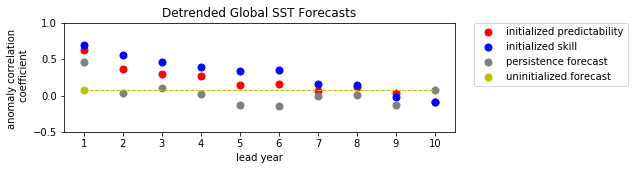

In [17]:
f, ax = plt.subplots(figsize=(7,2))

# Automatically computes pearson_r for the ensemble mean DPLE.
skill = dp.compute_metric()
persistence = dp.compute_persistence('FOSI')
uninit = dp.compute_uninitialized('FOSI')

# Show dashed line for reference
uninit = xr.concat([uninit]*10, 'lead')
uninit['lead'] = persistence['lead']

# Plot results
p1, = ax.plot(skill['FOSI'].lead, skill['FOSI'].SST,
        'o', markersize=7, label='initialized predictability',
        color='r')
p2, = ax.plot(skill['ERSST'].lead, skill['ERSST'].SST,
        'o', markersize=7, label='initialized skill',
        color='b')
p3, = ax.plot(persistence.lead, persistence.SST,
        'o', markersize=7, label='persistence forecast', color='gray')
p4, = ax.plot(uninit.lead[0], uninit.SST[0], 'o', markersize=7, color='y',
        label='uninitialized forecast')
ax.plot(uninit.lead, uninit.SST, '--', color='y', linewidth=1)

ax.set(ylim=[-0.5, 1], xlim=[0.5, 10.5],
       xlabel='lead year', ylabel='anomaly correlation \n coefficient',
       xticks=np.arange(1, 11))
ax.set_title('Detrended Global SST Forecasts', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.setp(plt.gca().get_legend().get_texts(), fontsize=10)
plt.show()

# Perfect Model Ensemble

---

This is a brief demo for the functionality of a `PerfectModelEnsemble` object. This has limited development thus far and will be expanded in future PRs.

Here, I use the MPI Perfect Model decadal prediction ensemble. More details on this can be found in the `perfect-model_predictability` notebook.

In [18]:
ds = open_dataset('MPI-PM-DP-1D')
control = open_dataset('MPI-control-1D')

# get working with just one variable.
area = 'global'
period = 'ym'
ds = ds.sel(area=area, period=period)
control = control.sel(area=area, period=period)

Similar to the `HindcastEnsemble`, you create your `PerfectModelEnsemble` object by adding the prediction model ensemble output. You can then run `add_control()` to add the complementary control run. Here, we add SST ('tos'), SSS ('sos'), and the Atlantic Multidecadal Oscillation index (AMO).

In [19]:
pm = cp.PerfectModelEnsemble(ds)
pm.add_control(control)
print(pm)

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (lead, init, member) float32 ...
    sos      (lead, init, member) float32 ...
    AMO      (lead, init, member) float32 ...
Control:
    tos      (time) float32 ...
    sos      (time) float32 ...
    AMO      (time) float32 ...
Uninitialized:
    None


Just as with the `HindcastEnsemble`, we can compare the initialized prediction ensemble to our control run and compute persistence forecasts for the control run.

In [20]:
# The default here is to compute the pearson r correlation with the 'm2e'
# comparison flag, which generates a supervector to compare all members to
# the ensemble mean.
result = pm.compute_metric(comparison='m2e')
print(result)

<xarray.Dataset>
Dimensions:  (lead: 20)
Coordinates:
    area     <U6 'global'
    period   <U2 'ym'
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    tos      (lead) float32 0.8211777 0.5992312 ... 0.02773353 0.089941345
    sos      (lead) float32 0.8980022 0.79848033 ... 0.12174402 0.08676403
    AMO      (lead) float32 0.6858465 0.51578045 ... 0.08524156 0.09244315


In [21]:
# Here, we compute a simple persistence forecast for all variables.
persist = pm.compute_persistence()
print(persist)

<xarray.Dataset>
Dimensions:  (lead: 20)
Coordinates:
    period   <U2 'ym'
    area     <U6 'global'
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
Data variables:
    tos      (lead) float32 0.21984895 0.14496486 ... -0.2252923 -0.3211129
    sos      (lead) float32 0.83350956 0.43976524 ... 0.13950764 -0.12547262
    AMO      (lead) float32 0.83411205 0.3055103 ... -0.046767987 0.14960702


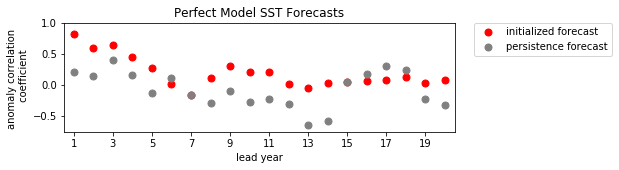

In [22]:
f, ax = plt.subplots(figsize=(7,2))
p1, = ax.plot(result.lead, result.tos, 'o', color='r', markersize=7,
        label='initialized forecast')
p2, = ax.plot(persist.lead, persist.tos, 'o', color='gray', markersize=7,
        label='persistence forecast')
ax.set(ylim=[-0.75, 1], xlim=[0.5, 20.5],
       ylabel='anomaly correlation \n coefficient',
       xlabel='lead year', xticks=np.arange(1, 21, 2))
ax.set_title('Perfect Model SST Forecasts', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.setp(plt.gca().get_legend().get_texts(), fontsize=10)
plt.show()

We can reproduce an exercise from the `perfect model` demo notebook here. Now, we use different comparison methods.

Text(0.5, 1.0, 'Different forecast-reference comparisons for pearson_r\n lead to systematically different magnitude of skill score')

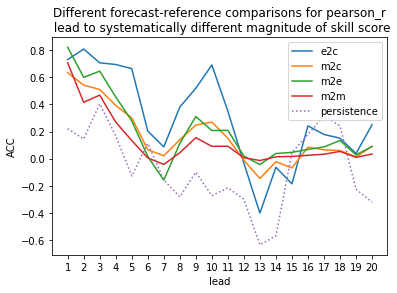

In [23]:
var = 'tos'
for c in ['e2c', 'm2c', 'm2e', 'm2m']:
    pm.compute_metric(comparison=c)[var].plot(label=c)
pm.compute_persistence(nlags=20)[var].plot(label='persistence', ls=':')
plt.ylabel('ACC')
plt.xticks(np.arange(1,21))
plt.legend()
plt.title('Different forecast-reference comparisons for pearson_r' +
          '\n lead to systematically different magnitude of skill score')